In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#    -O /tmp/daily-min-temperatures.csv

((3650,), (3650,))

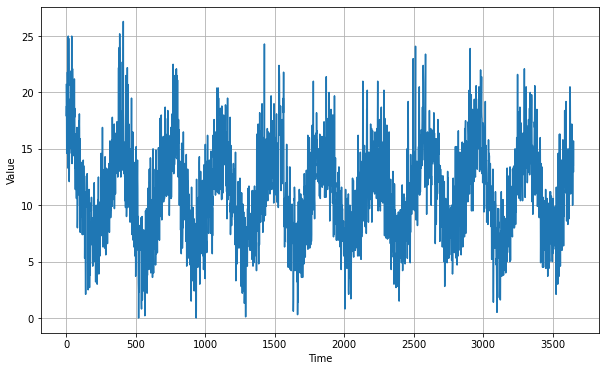

In [10]:
import csv
time_step = []
temps = []

with open('../../data/daily-min-temperatures.csv') as csvfile:
    # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
    # HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    i = 1
    for row in reader:
        time_step.append(i)
        i += 1
        temps.append(float(row[1]))
        
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)
series.shape, time.shape

In [11]:
split_time = 2500

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 40)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 26ms/step - loss: 12.4132 - mae: 12.9129
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 12.4919 - mae: 12.9916
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 12.4791 - mae: 12.9788
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 12.4124 - mae: 12.9120
Epoch 5/100
10/10 [==============================] - 0s 21ms/step - loss: 12.3851 - mae: 12.8848
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - loss: 12.3815 - mae: 12.8812
Epoch 7/100
10/10 [==============================] - 0s 21ms/step - loss: 12.4727 - mae: 12.9724
Epoch 8/100
10/10 [==============================] - 0s 21ms/step - loss: 12.4092 - mae: 12.9089
Epoch 9/100
10/10 [==============================] - 0s 21ms/step - loss: 12.3825 - mae: 12.8822
Epoch 10/100
10/10 [=====

10/10 [==============================] - 0s 21ms/step - loss: 1.7536 - mae: 2.2050
Epoch 85/100
10/10 [==============================] - 0s 21ms/step - loss: 1.7416 - mae: 2.1921
Epoch 86/100
10/10 [==============================] - 0s 21ms/step - loss: 1.7608 - mae: 2.2118
Epoch 87/100
10/10 [==============================] - 0s 21ms/step - loss: 1.8289 - mae: 2.2826
Epoch 88/100
10/10 [==============================] - 0s 21ms/step - loss: 1.7622 - mae: 2.2130
Epoch 89/100
10/10 [==============================] - 0s 21ms/step - loss: 1.7124 - mae: 2.1619
Epoch 90/100
10/10 [==============================] - 0s 21ms/step - loss: 1.7647 - mae: 2.2164
Epoch 91/100
10/10 [==============================] - 0s 23ms/step - loss: 1.7428 - mae: 2.1932
Epoch 92/100
10/10 [==============================] - 1s 75ms/step - loss: 1.7914 - mae: 2.2433
Epoch 93/100
10/10 [==============================] - 0s 21ms/step - loss: 1.7956 - mae: 2.2474
Epoch 94/100
10/10 [==============================] -

[1e-08, 0.0001, 0, 60]

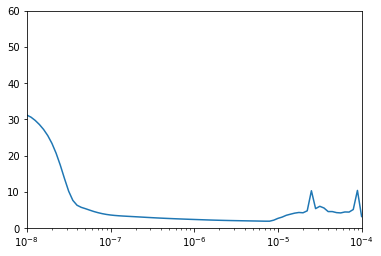

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
25/25 [==============================] - 3s 13ms/step - loss: 15.8471 - mae: 16.3395
Epoch 2/100
25/25 [==============================] - 0s 11ms/step - loss: 2.9319 - mae: 3.4000
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 2.0154 - mae: 2.4716
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 1.9116 - mae: 2.3667
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 1.8753 - mae: 2.3298
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 1.8385 - mae: 2.2917
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 1.8145 - mae: 2.2668
Epoch 8/100
25/25 [==============================] - 0s 12ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/100
25/25 [==============================] - 0s 12ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 1.7409 - mae: 2.1911
Epoch 11/100
25/25 [===========================

25/25 [==============================] - 0s 12ms/step - loss: 1.5328 - mae: 1.9751
Epoch 87/100
25/25 [==============================] - 0s 11ms/step - loss: 1.5348 - mae: 1.9767
Epoch 88/100
25/25 [==============================] - 0s 12ms/step - loss: 1.5339 - mae: 1.9759
Epoch 89/100
25/25 [==============================] - 0s 12ms/step - loss: 1.5300 - mae: 1.9722
Epoch 90/100
25/25 [==============================] - 0s 11ms/step - loss: 1.5381 - mae: 1.9804
Epoch 91/100
25/25 [==============================] - 0s 12ms/step - loss: 1.5292 - mae: 1.9712
Epoch 92/100
25/25 [==============================] - 0s 12ms/step - loss: 1.5301 - mae: 1.9724
Epoch 93/100
25/25 [==============================] - 0s 11ms/step - loss: 1.5271 - mae: 1.9691
Epoch 94/100
25/25 [==============================] - 0s 11ms/step - loss: 1.5342 - mae: 1.9769
Epoch 95/100
25/25 [==============================] - 0s 11ms/step - loss: 1.5336 - mae: 1.9764
Epoch 96/100
25/25 [==============================] -

In [23]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

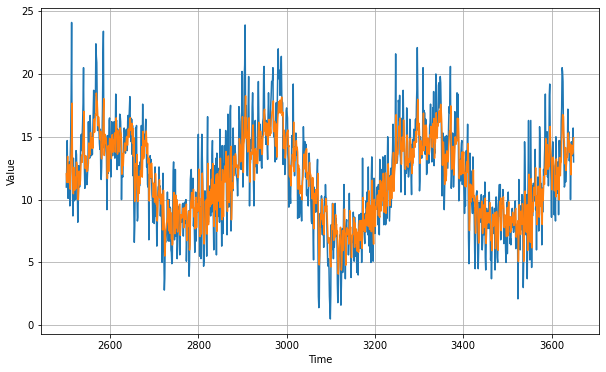

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7954093

In [21]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.051666 11.388111 12.39254  ... 13.655243 13.78126  14.915953]
